In [ ]:
%load_ext autoreload
%autoreload 2


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr


The goal of this notebook is to test the greedy algorithms for creating
basis functions using axis-parallel or "inertial" partitioning.

# Examples with real data

## Loading data

In [ ]:
merged_data = xr.open_dataset("~/Documents/openghg_inversions/tests/data/merged_data_test_tac_combined_scenario_v14.nc")
mean_fp_x_flux = merged_data.fp_x_flux.mean("time").squeeze("site")

weight_arr = mean_fp_x_flux.values
lat_coord = mean_fp_x_flux.lat.values
lon_coord = mean_fp_x_flux.lon.values


In [ ]:
land_sea_mask = xr.open_dataset("~/Documents/openghg_inversions/openghg_inversions/basis/algorithms/country-EUROPE-UKMO-landsea-2023.nc")
print(land_sea_mask)


In [ ]:
countries_ds = xr.open_dataset("~/Documents/openghg_inversions/tests/data/country_EUROPE.nc")
print(countries_ds)


In [ ]:
from openghg_inversions.postprocessing.countries import Countries

countries = Countries(countries_ds, country_code="alpha3")


In [ ]:
country_coord = countries.matrix.country
country_labels = xr.DataArray(np.arange(len(country_coord)), dims=["country"], coords=[country_coord])
countries_flat = countries.matrix @ country_labels
print(country_labels)
print(countries_flat)


In [ ]:
print(sorted(map(str, country_labels.country.values)))


InTEM outer regions:

``` shell
ls /Users/bm13805/documents/openghg_inversions/openghg_inversions/basis
```

In [ ]:
outer_regions = xr.open_dataset("/Users/bm13805/documents/openghg_inversions/openghg_inversions/basis/outer_region_definition_EUROPE.nc")
print(outer_regions)


Let's look at these region maps and the mean fp x flux.

In [ ]:
from inversions.plotting import plot_country_boundaries


In [ ]:
fig, ax = plt.subplots()

land_sea_mask.country.plot(ax=ax)
plot_country_boundaries(ax)


In [ ]:
fig, ax = plt.subplots()

countries_ds.country.plot(ax=ax)
plot_country_boundaries(ax)


In [ ]:
fig, ax = plt.subplots()

outer_regions.region.plot(ax=ax)
plot_country_boundaries(ax)


Finally, we'll plot the mean footprint times flux (on a log scale).

In [ ]:
fig, ax = plt.subplots()

np.log(mean_fp_x_flux).plot(ax=ax)
plot_country_boundaries(ax)


## Masking regions

In [ ]:
from inversions.basis_algorithms import node_list_from_mask, partition_data_array, partition_remainder


We can make a list of nodes corresponding to land and to sea using the
land/sea mask. If we convert this to a DataArray, it is the same as the
`country` variables of the land/sea mask.

Note: "node" here just means grid cell.

In [ ]:
land_sea_partition = [node_list_from_mask(land_sea_mask.country == i) for i in range(land_sea_mask.sizes["ncountries"])]
land_sea_part_da = partition_data_array(land_sea_partition, land_sea_mask.lat.values, land_sea_mask.lon.values)

fig, ax = plt.subplots()

land_sea_part_da.plot(ax=ax)
plot_country_boundaries(ax)


A more interesting option is to select a few countries whose totals
we're interested in, along with the ocean.

First we create node lists from a selection of regions:

In [ ]:
paris_country_list = ["OCEAN", "GBR", "DEU", "FRA", "ITA", "IRL", "BEL", "ESP", "NLD"]
paris_partition = [node_list_from_mask(countries_flat == country_labels.sel(country=c)) for c in paris_country_list]


Now we need to make a region with any missing nodes:

In [ ]:
remainder = partition_remainder(paris_partition, nx=countries_flat.sizes["lat"], ny=countries_flat.sizes["lon"])
paris_partition.append(remainder)


Now we can plot the result:

In [ ]:
paris_part_da = partition_data_array(paris_partition, countries_flat.lat.values, countries_flat.lon.values)

fig, ax = plt.subplots()

paris_part_da.plot(ax=ax)
plot_country_boundaries(ax)


Everything in yellow is one region, but this will be split by the basis
algorithms.

## Axis parallel partitions

The axis-parallel partitioning takes an initial partition and repeatedly
subdivides the regions until we have a target number of regions.

The algorithm is "greedy" in that the next region split is the one with
the highest "weight". This weight could be the number of nodes in the
region, or it could be the total value of a map like "mean footprint
times flux".

By default, splits are "balanced", so that each region in the split has
equal weight. If `balanced=False`, then regions are split so that they
have an equal number of nodes.

In the axis-parallel algorithm, splits are parallel to the x or y axis;
the direction is chosen so that the longer edge is split. (This doesn't
always work well with the balanced option, since the weight in the
region might not be uniformly distributed.) Also, the length is measured
assuming x and y coordinates have equal spacing, which isn't true on
lat/lon grids.

In [ ]:
from inversions.basis_algorithms import axis_parallel_partitioning, NodeList


In [ ]:
print(axis_parallel_partitioning.__doc__)


To plot the basis functions, we'll use the `BasisFunctions` class, which
shuffles the region labels to make the basis regions easier to see.

In [ ]:
from inversions.basis_functions import BasisFunctions


We'll make a helper function to make `BasisFunctions` objects from our
partitions since this involves a few steps.

In [ ]:
def basis_functions_from_partition(partition: list[NodeList]) -> BasisFunctions:
    bf_da = partition_data_array(partition, mean_fp_x_flux.lat, mean_fp_x_flux.lon)
    bf = BasisFunctions(bf_da, xr.ones_like(bf_da).expand_dims({"time": [pd.to_datetime("2019-01-01")]}))
    return bf


We'll also make a function to plot the basis functions with country
boundaries.

In [ ]:
def plot_bf_with_boundaries(bf: BasisFunctions, xlim=None, ylim=None, ax=None, shuffle: bool = True, colorbar: bool = False, **kwargs) -> None:
    if ax is None:
        _, ax = plt.subplots()

    bfp = bf.plot(shuffle=shuffle, ax=ax, add_colorbar=colorbar, **kwargs)
    plot_country_boundaries(ax)

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)


I'm having trouble getting good colors to distinguish nearby basis
regions. Here is some [code from
stackoverflow](https://stackoverflow.com/questions/42697933/colormap-with-maximum-distinguishable-colours)
to make "distinguishable" colormaps:

In [ ]:
import math

import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv


def generate_colormap(number_of_distinct_colors: int = 80):
    if number_of_distinct_colors == 0:
        number_of_distinct_colors = 80

    number_of_shades = 7
    number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)

    # Create an array with uniformly drawn floats taken from <0, 1) partition
    linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades

    # We are going to reorganise monotonically growing numbers in such way that there will be single array with saw-like pattern
    #     but each saw tooth is slightly higher than the one before
    # First divide linearly_distributed_nums into number_of_shades sub-arrays containing linearly distributed numbers
    arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

    # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
    arr_by_shade_columns = arr_by_shade_rows.T

    # Keep number of saw teeth for later
    number_of_partitions = arr_by_shade_columns.shape[0]

    # Flatten the above matrix - join each row into single array
    nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)

    # HSV colour map is cyclic (https://matplotlib.org/tutorials/colors/colormaps.html#cyclic), we'll use this property
    initial_cm = hsv(nums_distributed_like_rising_saw)

    lower_partitions_half = number_of_partitions // 2
    upper_partitions_half = number_of_partitions - lower_partitions_half

    # Modify lower half in such way that colours towards beginning of partition are darker
    # First colours are affected more, colours closer to the middle are affected less
    lower_half = lower_partitions_half * number_of_shades
    for i in range(3):
        initial_cm[0:lower_half, i] *= np.arange(0.2, 1, 0.8/lower_half)

    # Modify second half in such way that colours towards end of partition are less intense and brighter
    # Colours closer to the middle are affected less, colours closer to the end are affected more
    for i in range(3):
        for j in range(upper_partitions_half):
            modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
            modifier = j * modifier / upper_partitions_half
            initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

    return ListedColormap(initial_cm)



Let's try to make the plots bigger too

``` elisp
(setq-local org-image-actual-width '(900))
```

### Partitioning without a mask

First we make an initial partition with one region. (InTEM "inner
region".)

In [ ]:
#init_part_one_region = [partition_remainder([], nx=mean_fp_x_flux.sizes["lat"], ny=mean_fp_x_flux.sizes["lon"])]
init_part_one_region = [node_list_from_mask(outer_regions.region == 6)]


First, we'll make a balanced partition:

In [ ]:
ap_bal_part = axis_parallel_partitioning(init_part_one_region, n_parts=200, weights=weight_arr, balanced=True)

ap_bal_part_bf = basis_functions_from_partition(ap_bal_part)
plot_bf_with_boundaries(ap_bal_part_bf)


These thin regions (e.g. around the UK) seem typical of this method. It
might be due to the poor choice of "long" axis in the balanced case.

Let's zoom in to Europe:

In [ ]:
europe_lims = {"xlim": [-20, 20], "ylim": [30, 70]}
uk_lims = {"xlim": [-12, 5], "ylim": [47, 62]}

plot_bf_with_boundaries(ap_bal_part_bf, **europe_lims)


Now we'll partition into regions of equal size, instead of equal weight.

In [ ]:
ap_unbal_part = axis_parallel_partitioning(init_part_one_region, n_parts=200, weights=weight_arr, balanced=False, clean_splits=True)

ap_unbal_part_bf = basis_functions_from_partition(ap_unbal_part)
plot_bf_with_boundaries(ap_unbal_part_bf)


Zoomed in:

In [ ]:
# plot_bf_with_boundaries(ap_unbal_part_bf, **europe_lims)
plot_bf_with_boundaries(ap_unbal_part_bf, **uk_lims)


Let's plot the UK regions side-by-side:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, layout="constrained")

plot_bf_with_boundaries(ap_bal_part_bf, **uk_lims, ax=axs[0], colorbar=False)
plot_bf_with_boundaries(ap_unbal_part_bf, **uk_lims, ax=axs[1], colorbar=False)


Another peculiarity here is that the "unbalanced" splits are by the
number of nodes, rather than by x or y coordinate exactly, so there are
"steps" on the boundaries.

### Land/sea mask

The process for creating basis functions with masks is the same, but we
specify a different initial position.

In [ ]:
land_sea_ap_bal_part = axis_parallel_partitioning(land_sea_partition, n_parts=200, weights=weight_arr, balanced=True)

land_sea_ap_bal_part_bf = basis_functions_from_partition(land_sea_ap_bal_part)
plot_bf_with_boundaries(land_sea_ap_bal_part_bf)



Zoomed in to Europe:

In [ ]:
plot_bf_with_boundaries(land_sea_ap_bal_part_bf, **europe_lims)


This is generally better, but we still have "stripes" across North
Africa.

Now for the "unbalanced" version.

In [ ]:
land_sea_ap_unbal_part = axis_parallel_partitioning(land_sea_partition, n_parts=200, weights=weight_arr, balanced=False, clean_splits=True)

land_sea_ap_unbal_part_bf = basis_functions_from_partition(land_sea_ap_unbal_part)
plot_bf_with_boundaries(land_sea_ap_unbal_part_bf)


In [ ]:
plot_bf_with_boundaries(land_sea_ap_unbal_part_bf, **europe_lims)


There aren't as many thin regions, but the partitioning of the ocean is
less efficient.

Side-by-side UK comparison:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, layout="constrained")

plot_bf_with_boundaries(land_sea_ap_bal_part_bf, **europe_lims, ax=axs[0], colorbar=False, cmap=generate_colormap(200))
plot_bf_with_boundaries(land_sea_ap_unbal_part_bf, **europe_lims, ax=axs[1], colorbar=False, cmap=generate_colormap(200))


### PARIS mask

In [ ]:
paris_ap_bal_part = axis_parallel_partitioning(paris_partition, n_parts=200, weights=weight_arr, balanced=True)

paris_ap_bal_part_bf = basis_functions_from_partition(paris_ap_bal_part)
plot_bf_with_boundaries(paris_ap_bal_part_bf)



Zoomed in to Europe:

In [ ]:
plot_bf_with_boundaries(paris_ap_bal_part_bf, **europe_lims)


This has stripes again. This might be due to some difference between
selecting "OCEAN" as a country and using the land/sea mask.

Now for the "unbalanced" version.

In [ ]:
paris_ap_unbal_part = axis_parallel_partitioning(paris_partition, n_parts=200, weights=weight_arr, balanced=False, clean_splits=True)

paris_ap_unbal_part_bf = basis_functions_from_partition(paris_ap_unbal_part)
plot_bf_with_boundaries(paris_ap_unbal_part_bf)


In [ ]:
plot_bf_with_boundaries(paris_ap_unbal_part_bf, **europe_lims)


Again, there aren't as many thin regions, but the partitioning of the
ocean is less efficient.

Side-by-side UK comparison:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, layout="constrained")

# shuffle coords again
# np.random.shuffle(paris_ap_bal_part_bf.labels_shuffled)

plot_bf_with_boundaries(paris_ap_bal_part_bf, **uk_lims, ax=axs[0], shuffle=False, colorbar=False, cmap=generate_colormap(100))
plot_bf_with_boundaries(paris_ap_unbal_part_bf, **uk_lims, ax=axs[1], shuffle=False, colorbar=False, cmap=generate_colormap(100))


So we can see the "balanced" version has fewer ocean regions (but still
has the "strips" issue).

## Inertial partitioning

Inertial partitioning uses the same greedy algorithm as axis-parallel
partitioning, but instead of splitting parallel to the x or y axis,
splits are done perpendicular to a line that minimises the "moment of
inertia" of the points in a region.

If the region was an ellipse and all weights were equal, then this line
would be the longer (major) axis of the ellipse, and the region would be
split by the smaller (minor) axis of the ellipse.

Again, we can balance the split so there is equal weight in the two
subparts, or we can split so they have an equal number of nodes
(unbalanced).

In [ ]:
from inversions.basis_algorithms import inertial_partitioning


### Single region

First, we'll make a balanced partition:

In [ ]:
in_bal_part = inertial_partitioning(init_part_one_region, n_parts=10, weights=weight_arr, balanced=True)

in_bal_part_bf = basis_functions_from_partition(in_bal_part)
plot_bf_with_boundaries(in_bal_part_bf, shuffle=False)


In [ ]:
plot_bf_with_boundaries(in_bal_part_bf, **europe_lims)


Again, there is a "strip" issue.

Now we'll make unbalanced partitions.

In [ ]:
in_unbal_part = inertial_partitioning(init_part_one_region, n_parts=200, weights=weight_arr, balanced=False)

in_unbal_part_bf = basis_functions_from_partition(in_unbal_part)
plot_bf_with_boundaries(in_unbal_part_bf)


In [ ]:
plot_bf_with_boundaries(in_unbal_part_bf, **europe_lims)


Now we'll compare the UK basis regions:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, layout="constrained")

# shuffle coords again
# np.random.shuffle(paris_ap_bal_part_bf.labels_shuffled)

plot_bf_with_boundaries(in_bal_part_bf, **uk_lims, ax=axs[0], shuffle=False, colorbar=False, cmap=generate_colormap(100))
plot_bf_with_boundaries(in_unbal_part_bf, **uk_lims, ax=axs[1], shuffle=False, colorbar=False, cmap=generate_colormap(100))


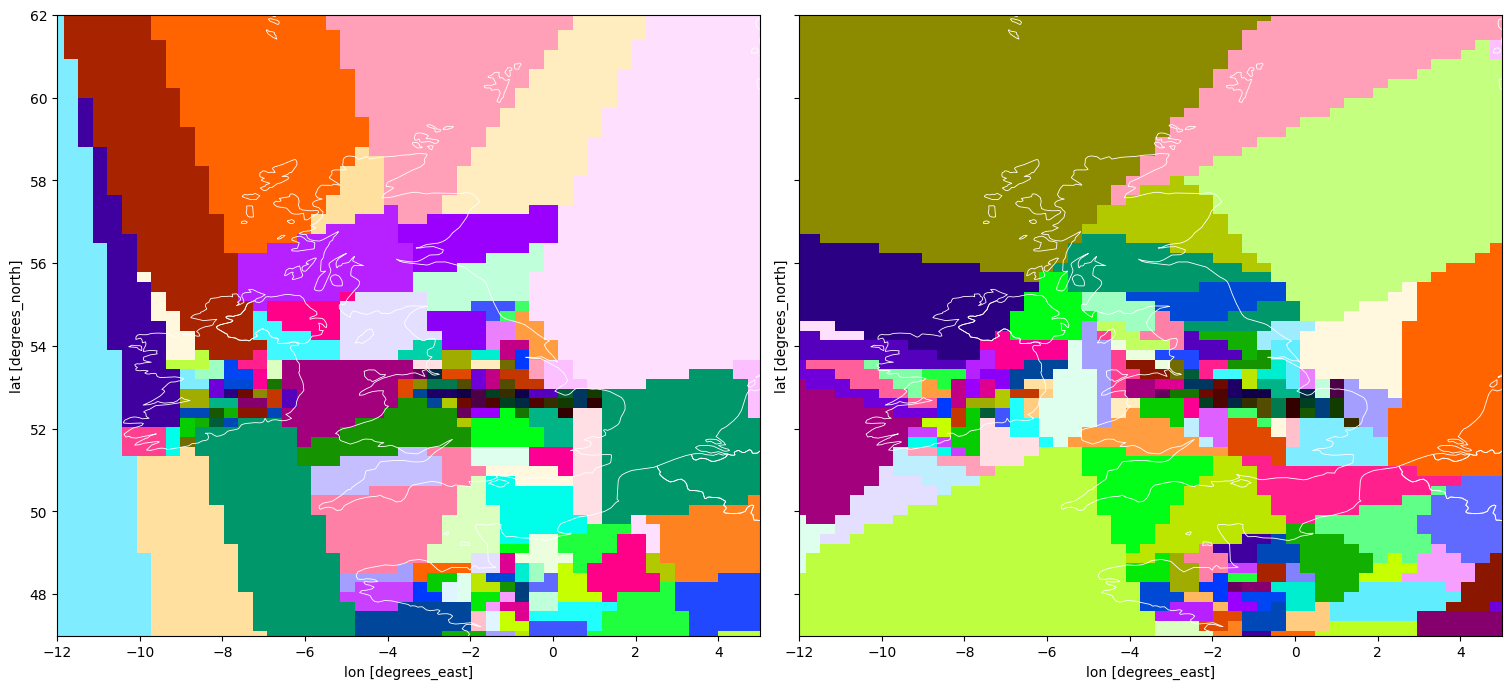

…it's pretty hard to see what is going on.

### Land/sea mask

First, we'll make a balanced partition:

In [ ]:
land_sea_in_bal_part = inertial_partitioning(land_sea_partition, n_parts=200, weights=weight_arr, balanced=True)

land_sea_in_bal_part_bf = basis_functions_from_partition(land_sea_in_bal_part)
plot_bf_with_boundaries(land_sea_in_bal_part_bf)


In [ ]:
plot_bf_with_boundaries(land_sea_in_bal_part_bf, **europe_lims)


Again, there is a "strip" issue… maybe we need to put limits on how
"eccentric" a region can be.

Now we'll make unbalanced partitions.

In [ ]:
land_sea_in_unbal_part = inertial_partitioning(land_sea_partition, n_parts=200, weights=weight_arr, balanced=False)

land_sea_in_unbal_part_bf = basis_functions_from_partition(land_sea_in_unbal_part)
plot_bf_with_boundaries(land_sea_in_unbal_part_bf)


In [ ]:
plot_bf_with_boundaries(land_sea_in_unbal_part_bf, **europe_lims)


This is generally better looking. There are weird regions in N. Africa
because the land/sea split map groups Africa with "OCEAN".

Now we'll compare the UK basis regions:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, layout="constrained")

# shuffle coords again
# np.random.shuffle(paris_ap_bal_part_bf.labels_shuffled)

plot_bf_with_boundaries(land_sea_in_bal_part_bf, **uk_lims, ax=axs[0], shuffle=False, colorbar=False, cmap=generate_colormap(100))
plot_bf_with_boundaries(land_sea_in_unbal_part_bf, **uk_lims, ax=axs[1], shuffle=False, colorbar=False, cmap=generate_colormap(100))


### PARIS mask

First, we'll make a balanced partition:

In [ ]:
paris_in_bal_part = inertial_partitioning(paris_partition, n_parts=200, weights=weight_arr, balanced=True)

paris_in_bal_part_bf = basis_functions_from_partition(paris_in_bal_part)
plot_bf_with_boundaries(paris_in_bal_part_bf)


In [ ]:
plot_bf_with_boundaries(paris_in_bal_part_bf, **europe_lims)


Again, there is a "strip" issue… It seems like there are some ocean
regions that bridges land (e.g. from Iceland to Algeria).

Now we'll make unbalanced partitions.

In [ ]:
paris_in_unbal_part = inertial_partitioning(paris_partition, n_parts=200, weights=weight_arr, balanced=False)

paris_in_unbal_part_bf = basis_functions_from_partition(paris_in_unbal_part)
plot_bf_with_boundaries(paris_in_unbal_part_bf)


In [ ]:
plot_bf_with_boundaries(paris_in_unbal_part_bf, **europe_lims)


This is generally better looking. There are weird regions in N. Africa
because the land/sea split map groups Africa with "OCEAN".

Now we'll compare the UK basis regions:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, layout="constrained")

# shuffle coords again
# np.random.shuffle(paris_ap_bal_part_bf.labels_shuffled)

plot_bf_with_boundaries(paris_in_bal_part_bf, **uk_lims, ax=axs[0], shuffle=False, colorbar=False, cmap=generate_colormap(200))
plot_bf_with_boundaries(paris_in_unbal_part_bf, **uk_lims, ax=axs[1], shuffle=False, colorbar=False, cmap=generate_colormap(200))


### PARIS partitions on InTEM inner region

In [ ]:
inner_region = set(node_list_from_mask(outer_regions.region.values == 6))
paris_partition_inner = [set(part).intersection(inner_region) for part in paris_partition]
paris_partition_inner = [list(p) for p in paris_partition_inner if p]


First, we'll make a balanced partition:

In [ ]:
paris_in_bal_part = inertial_partitioning(paris_partition_inner, n_parts=200, weights=weight_arr, balanced=True)

paris_in_bal_part_bf = basis_functions_from_partition(paris_in_bal_part)
plot_bf_with_boundaries(paris_in_bal_part_bf)


In [ ]:
plot_bf_with_boundaries(paris_in_bal_part_bf, **europe_lims)


The "strip" issue is mostly fixed. (This comes from the early partitions
involving the ocean, Africa, and the Americas)

Now we'll make unbalanced partitions.

In [ ]:
paris_in_unbal_part = inertial_partitioning(paris_partition_inner, n_parts=200, weights=weight_arr, balanced=False)

paris_in_unbal_part_bf = basis_functions_from_partition(paris_in_unbal_part)
plot_bf_with_boundaries(paris_in_unbal_part_bf)


In [ ]:
plot_bf_with_boundaries(paris_in_unbal_part_bf, **europe_lims)


This is generally better looking. There are weird regions in N. Africa
because the land/sea split map groups Africa with "OCEAN".

Now we'll compare the UK basis regions:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, layout="constrained")

# shuffle coords again
# np.random.shuffle(paris_ap_bal_part_bf.labels_shuffled)

plot_bf_with_boundaries(paris_in_bal_part_bf, **uk_lims, ax=axs[0], shuffle=False, colorbar=False, cmap=generate_colormap(200))
plot_bf_with_boundaries(paris_in_unbal_part_bf, **uk_lims, ax=axs[1], shuffle=False, colorbar=False, cmap=generate_colormap(200))


Comparing Europe

In [ ]:

intem_ylim = [lat_coord[min(inner_region, key=lambda x: x[0])[0]], lat_coord[max(inner_region, key=lambda x: x[0])[0]]]
intem_xlim = [lon_coord[min(inner_region, key=lambda x: x[1])[1]], lon_coord[max(inner_region, key=lambda x: x[1])[1]]]
intem_lims = {"xlim": intem_xlim, "ylim": intem_ylim}


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, layout="constrained")

# shuffle coords again
# np.random.shuffle(paris_ap_bal_part_bf.labels_shuffled)

plot_bf_with_boundaries(paris_in_bal_part_bf, **intem_lims, ax=axs[0], shuffle=False, colorbar=False, cmap=generate_colormap(200))
plot_bf_with_boundaries(paris_in_unbal_part_bf, **intem_lims, ax=axs[1], shuffle=False, colorbar=False, cmap=generate_colormap(200))


### Inertial vs. axis-parallel

Let's compare the inertial basis regions vs. the axis-parallel
unbalanced case, which is most similar to our current method.

In [ ]:
paris_inner_ap_unbal_part = axis_parallel_partitioning(paris_partition_inner, n_parts=200, weights=weight_arr, balanced=False, clean_splits=True)
paris_inner_ap_unbal_bf = basis_functions_from_partition(paris_inner_ap_unbal_part)


In [ ]:
paris_inner_ap_bal_part = axis_parallel_partitioning(paris_partition_inner, n_parts=200, weights=weight_arr, balanced=True, clean_splits=False)
paris_inner_ap_bal_bf = basis_functions_from_partition(paris_inner_ap_bal_part)


Comparing InTEM inner region:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, layout="constrained")

# shuffle coords again
# np.random.shuffle(paris_ap_bal_part_bf.labels_shuffled)
# np.random.shuffle(paris_inner_ap_unbal_bf.labels_shuffled)

plot_bf_with_boundaries(paris_in_bal_part_bf, **intem_lims, ax=axs[0], shuffle=True, colorbar=False, cmap=generate_colormap(200))
plot_bf_with_boundaries(paris_inner_ap_unbal_bf, **intem_lims, ax=axs[1], shuffle=True, colorbar=False, cmap=generate_colormap(200))
# plot_bf_with_boundaries(paris_inner_ap_bal_bf, **intem_lims, ax=axs[1], shuffle=True, colorbar=False, cmap=generate_colormap(200))


Comparing the UK:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, layout="constrained")

# shuffle coords again
# np.random.shuffle(paris_ap_bal_part_bf.labels_shuffled)

plot_bf_with_boundaries(paris_in_bal_part_bf, **uk_lims, ax=axs[0], shuffle=True, colorbar=False, cmap=generate_colormap(200))
plot_bf_with_boundaries(paris_inner_ap_unbal_bf, **uk_lims, ax=axs[1], shuffle=True, colorbar=False, cmap=generate_colormap(200))
#  plot_bf_with_boundaries(paris_inner_ap_bal_bf, **uk_lims, ax=axs[1], shuffle=True, colorbar=False, cmap=generate_colormap(200))


## Summarising the "quality" of the basis functions

We can measure how efficient our basis functions are by comparing the
weight in each region to the total average weight.

In [ ]:
def partition_cost(partition: list[NodeList], weight_arr: np.ndarray) -> float:
    n = len(partition)
    part_weights = [sum(weight_arr[split_node_list(part)]) for part in partition]
    avg_weight = sum(part_weights) / n

    return sum(abs(pw - avg_weight) for pw in part_weights) / n


In [ ]:
partitions = [paris_in_bal_part, paris_in_unbal_part, paris_inner_ap_bal_part, paris_inner_ap_unbal_part]

for partition in partitions:
    print(partition_cost(partition, weight_arr))


Surprisingly, the axis parallel balanced partition is slightly better
than the inertial balanced partition. I suppose this is a consequence of
the greedy algorithm: the inertial splits are more general than the
axis-parallel splits, but we might not make the splits in the best
possible order.

Part of the "cost" of the partition is due to very large weights in
single nodes.

In [ ]:
def irreducible_partition_cost(weight_arr: np.ndarray, n: int, thres: float = 1.1) -> float:
    avg_weight = weight_arr.sum() / n
    big_weights = weight_arr[weight_arr > thres * avg_weight]
    return np.sum(np.abs(big_weights - avg_weight)) / n


In [ ]:
irreducible_partition_cost(weight_arr[np.where(outer_regions.region.values == 6)], n=200, thres=2.0)


So about a third of the cost of the two best partitions is due to nodes
(grid cells) whose weight is twice the average weight.

This leaves open the possibility of improving our partitions further.

# Tests with synthetic data

In [ ]:
weight_arr = np.arange(64).reshape(8, 8)
weight_arr


In [ ]:
#nodes = [(0, 7), (1, 6), (2, 5), (3, 4), (4, 3), (5, 2), (6, 1), (7, 0), (7, 7)]
nodes = []
for i in range(8):
    for j in range(8):
        if i + j >= 7:
            nodes.append((i, j))

plt.scatter([n[0] for n in nodes], [n[1] for n in nodes])
plt.imshow(weight_arr.T, origin="lower")
plt.colorbar()


In [ ]:
nodes_tall = [(i, j) for i in range(3, 5) for j in range(8)]
nodes_wide = [(i, j) for i in range(8) for j in range(3, 5)]


In [ ]:
from inversions.basis_algorithms import split_node_list

plt.scatter(*split_node_list(nodes_tall), color="orange")
plt.scatter(*split_node_list(nodes_wide), color="blue")
plt.imshow(weight_arr.T, origin="lower")
plt.colorbar()


## Trying to fix bad axis-parallel balanced splits

Let's look at the axis-parallel split for our example above.

In [ ]:
from inversions.basis_algorithms import axis_parallel_split

a1, b1 = axis_parallel_split(nodes, weight_arr, balanced=True, clean_splits=True)
a2, b2 = axis_parallel_split(nodes, weight_arr, balanced=False, clean_splits=True)


First we'll plot the balanced partition, then the unbalanced.

In [ ]:
plt.scatter([n[0] for n in a1], [n[1] for n in a1], color="orange")
plt.scatter([n[0] for n in b1], [n[1] for n in b1], color="blue")
plt.imshow(weight_arr.T, origin="lower")
plt.colorbar()


In [ ]:
plt.scatter([n[0] for n in a2], [n[1] for n in a2], color="orange")
plt.scatter([n[0] for n in b2], [n[1] for n in b2], color="blue")
plt.imshow(weight_arr.T, origin="lower")
plt.colorbar()


Notes:

1.  axis 0 (x-axis) was chosen as the long axis by default, since the
    projections onto the x and y axes are the same; hence the split is
    perpendicular to the x-axis
2.  the splits are into equal numbers in the unbalanced case, even
    though this changes classes in the middle of a column.

Now, if we remove the node (0, 7), this will make the y-axis the longer
axis, and the splits will be different.

In [ ]:
nodes2 = nodes.copy()
nodes2.remove((0, 7))


In [ ]:
a1, b1 = axis_parallel_split(nodes2, weight_arr, balanced=True)
a2, b2 = axis_parallel_split(nodes2, weight_arr, balanced=False)


First we'll plot the balanced partition, then the unbalanced.

In [ ]:
plt.scatter([n[0] for n in a1], [n[1] for n in a1], color="orange")
plt.scatter([n[0] for n in b1], [n[1] for n in b1], color="blue")
plt.imshow(weight_arr.T, origin="lower")
plt.colorbar()


In [ ]:
plt.scatter([n[0] for n in a2], [n[1] for n in a2], color="orange")
plt.scatter([n[0] for n in b2], [n[1] for n in b2], color="blue")
plt.imshow(weight_arr.T, origin="lower")
plt.colorbar()


### Improving axis selection in weighted case

We saw that removing the node (0, 7) from the node list above changed
the long axis from the x-axis to the y-axis.

Let's look at how the "long axis" is selected.

In [ ]:
from inversions.basis_algorithms import long_axis, long_axis_weighted


In [ ]:
print(long_axis(nodes), long_axis(nodes2), long_axis(nodes_tall), long_axis(nodes_wide))


Here is a weighted version (which isn't used in the examples above yet…)

In [ ]:
print(long_axis_weighted(nodes, weight_arr), long_axis_weighted(nodes2, weight_arr), long_axis_weighted(nodes_tall, weight_arr), long_axis_weighted(nodes_wide, weight_arr))


In [ ]:
from inversions.basis_algorithms import centroid

print(centroid(nodes, weight_arr[split_node_list(nodes)]), centroid(nodes2, weight_arr[split_node_list(nodes2)]), centroid(nodes_tall, weight_arr[split_node_list(nodes_tall)]), centroid(nodes_wide, weight_arr[split_node_list(nodes_wide)]))


In [ ]:
nodes_all = [(i, j) for i in range(8) for j in range(8)]
nodes_lower = [n for n in nodes_all if n not in nodes]
for x in [nodes, nodes2, nodes_tall, nodes_wide, nodes_all, nodes_lower]:
    weights = weight_arr[split_node_list(x)]

    parr = np.array(x)
    warr = np.array(weights).reshape(-1, 1)

    c = (parr * warr).sum(axis=0) / warr.sum()

    spread = (warr * (parr - c)**2).sum(axis=0) / warr.sum()
    spread_l1 = (warr * np.abs(parr - c)).sum(axis=0) / warr.sum()

    print(c, spread, spread_l1)
